--Decimation--

Yann Parot

14/06/2023

Fréquence de sortie amp squid

In [2]:
import numpy as np

tsettling_DAC=12e-6

frow=6.25e6

decimation_factor = np.ceil(np.log2(frow*tsettling_DAC))
fs_DAC=frow/2**decimation_factor

print("facteur de decimation: "+str(2**decimation_factor))
print("fréquence d'échantillonnage du DAC: "+str(fs_DAC)+" Hz")

facteur de decimation: 128.0
fréquence d'échantillonnage du DAC: 48828.125 Hz


In [3]:
#plot frequentiel de filtre
import matplotlib.pyplot as plt

def plot_FIR(f,h,titre,ylim):
    
    fig = plt.figure(figsize=(30,10))
    
    ax = fig.add_subplot(111)

    ax.plot(f, 20*np.log10(np.abs(h)))

    ax.set_ylim(ylim, 5)

    ax.grid(True)

    ax.set_xlabel('Fréquence (Hz)')

    ax.set_ylabel('Gain (dB)')

    ax.set_title(titre)

Pour des raisons d'optimisation la décimation se fait en deux étapes: une première décimation grossière pour ne pas surcontraindre le filtre et une deuxième avec un filtre plus raide
- 1er FIR fenêtre blackman
- 2ème FIR equiripple

Pour l'atténuation en stopband, si on considère que le signal a, sans la fonctionalité FLL, un bruit de 15nV/sqrtHz sur une bande de 160MHz TBC, alors on choisit un post de bruit du a l'aliasing 4 fois inférieur.
Ainsi l'atténuation de fréquences repliées doit être au minimum de:

In [4]:
V_FS_DAC=1 #V
Vnoise_out=15e-9 #V/sqrtHz
BW_fast=160e6
Vpp_Alias=Vnoise_out/4*np.sqrt(BW_fast)*6
Att_Stopband=Vpp_Alias/V_FS_DAC
print("L'atténuation dans la stopband doit être de: "+str(20*np.log10(Att_Stopband)))

L'atténuation dans la stopband doit être de: -70.91514981121351


Le premier filtre est taillé pour décimer par 2^5=32 et le second par 4.

[-2.57342373e-20  8.96358117e-08  3.07405073e-07  5.67677642e-07
  7.74762943e-07  8.25442367e-07  6.11763063e-07  2.40636296e-08
 -1.04580201e-06 -2.70108090e-06 -5.03662068e-06 -8.13530119e-06
 -1.20644517e-05 -1.68723128e-05 -2.25846083e-05 -2.92012947e-05
 -3.66935638e-05 -4.50011741e-05 -5.40301926e-05 -6.36512254e-05
 -7.36982212e-05 -8.39679248e-05 -9.42200568e-05 -1.04178289e-04
 -1.13532080e-04 -1.21939415e-04 -1.29030504e-04 -1.34412446e-04
 -1.37674883e-04 -1.38396620e-04 -1.36153197e-04 -1.30525341e-04
 -1.21108238e-04 -1.07521522e-04 -8.94198527e-05 -6.65039394e-05
 -3.85318456e-05 -5.33037357e-06  3.31936747e-05  7.70425910e-05
  1.26117452e-04  1.80208659e-04  2.38987587e-04  3.01999606e-04
  3.68658728e-04  4.38244134e-04  5.09898817e-04  5.82630557e-04
  6.55315417e-04  7.26703919e-04  7.95430043e-04  8.60023104e-04
  9.18922567e-04  9.70495787e-04  1.01305860e-03  1.04489866e-03
  1.06430132e-03  1.06957790e-03  1.05909590e-03  1.03131102e-03
  9.84800391e-04  9.18296

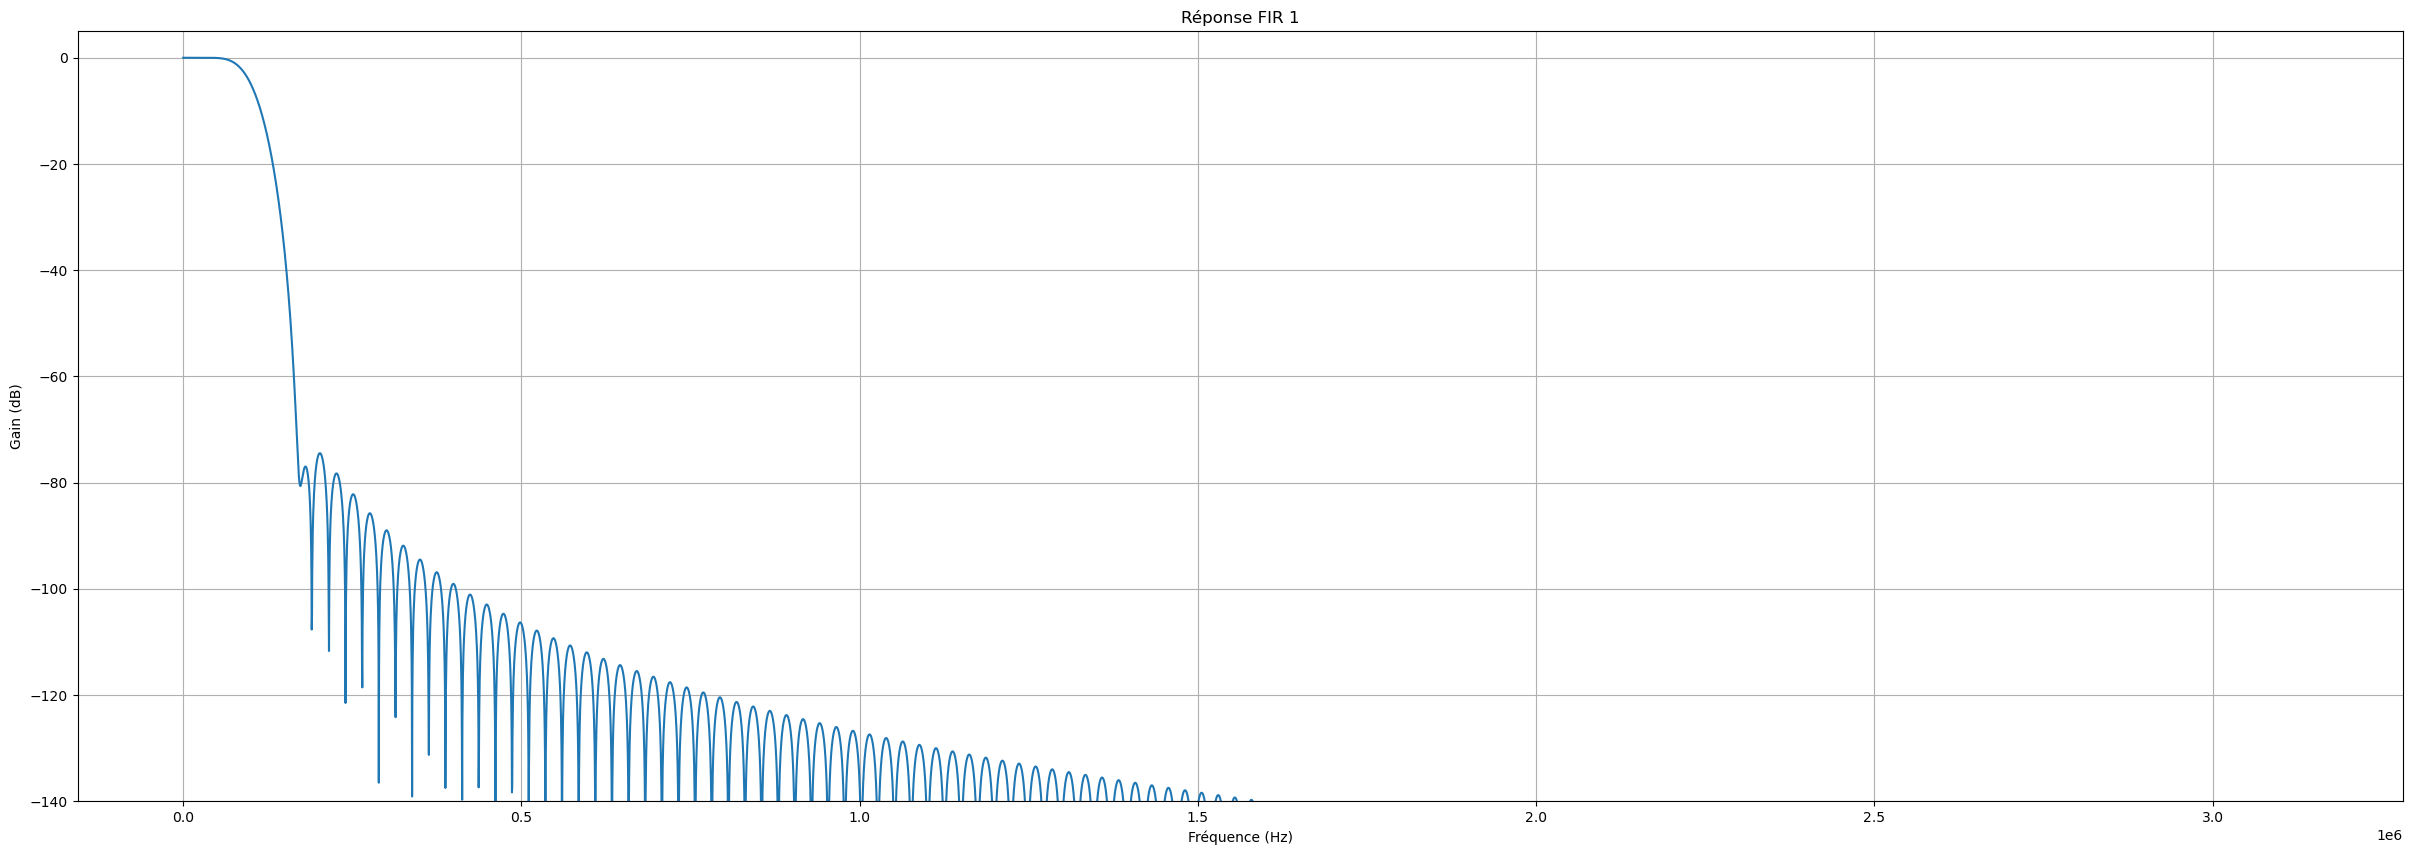

Ripple dans la bande d'intérêt: +/- 0.0002499201444410293
Atténuation minimum dans la stopband:  -7.246154288553479
[-4.92418740e-05 -2.17321195e-05 -9.39686993e-06  1.33631009e-05
  3.36510421e-05  4.13688453e-05  2.64029196e-05 -5.74150354e-06
 -4.33829220e-05 -6.40667690e-05 -5.49259618e-05 -1.25905476e-05
  4.37586062e-05  8.80205237e-05  9.12708746e-05  4.68717896e-05
 -3.14880862e-05 -1.04411160e-04 -1.33868023e-04 -9.48370123e-05
 -5.92376236e-07  1.08529162e-04  1.73484611e-04  1.55929314e-04
  5.19959663e-05 -9.11635032e-05 -2.04366379e-04 -2.21088543e-04
 -1.23845389e-04  5.08406891e-05  2.15713080e-04  2.84525733e-04
  2.08215792e-04  1.56744247e-05 -2.04379742e-04 -3.34569351e-04
 -3.00010031e-04 -1.01854211e-04  1.65406673e-04  3.67420408e-04
  3.87897310e-04  2.04139490e-04 -1.03989195e-04 -3.77357592e-04
 -4.68794061e-04 -3.12409377e-04  2.23582415e-05  3.69600257e-04
  5.38006306e-04  4.25607014e-04  7.05567569e-05 -3.46503007e-04
 -6.03148111e-04 -5.42125829e-04 -1.763

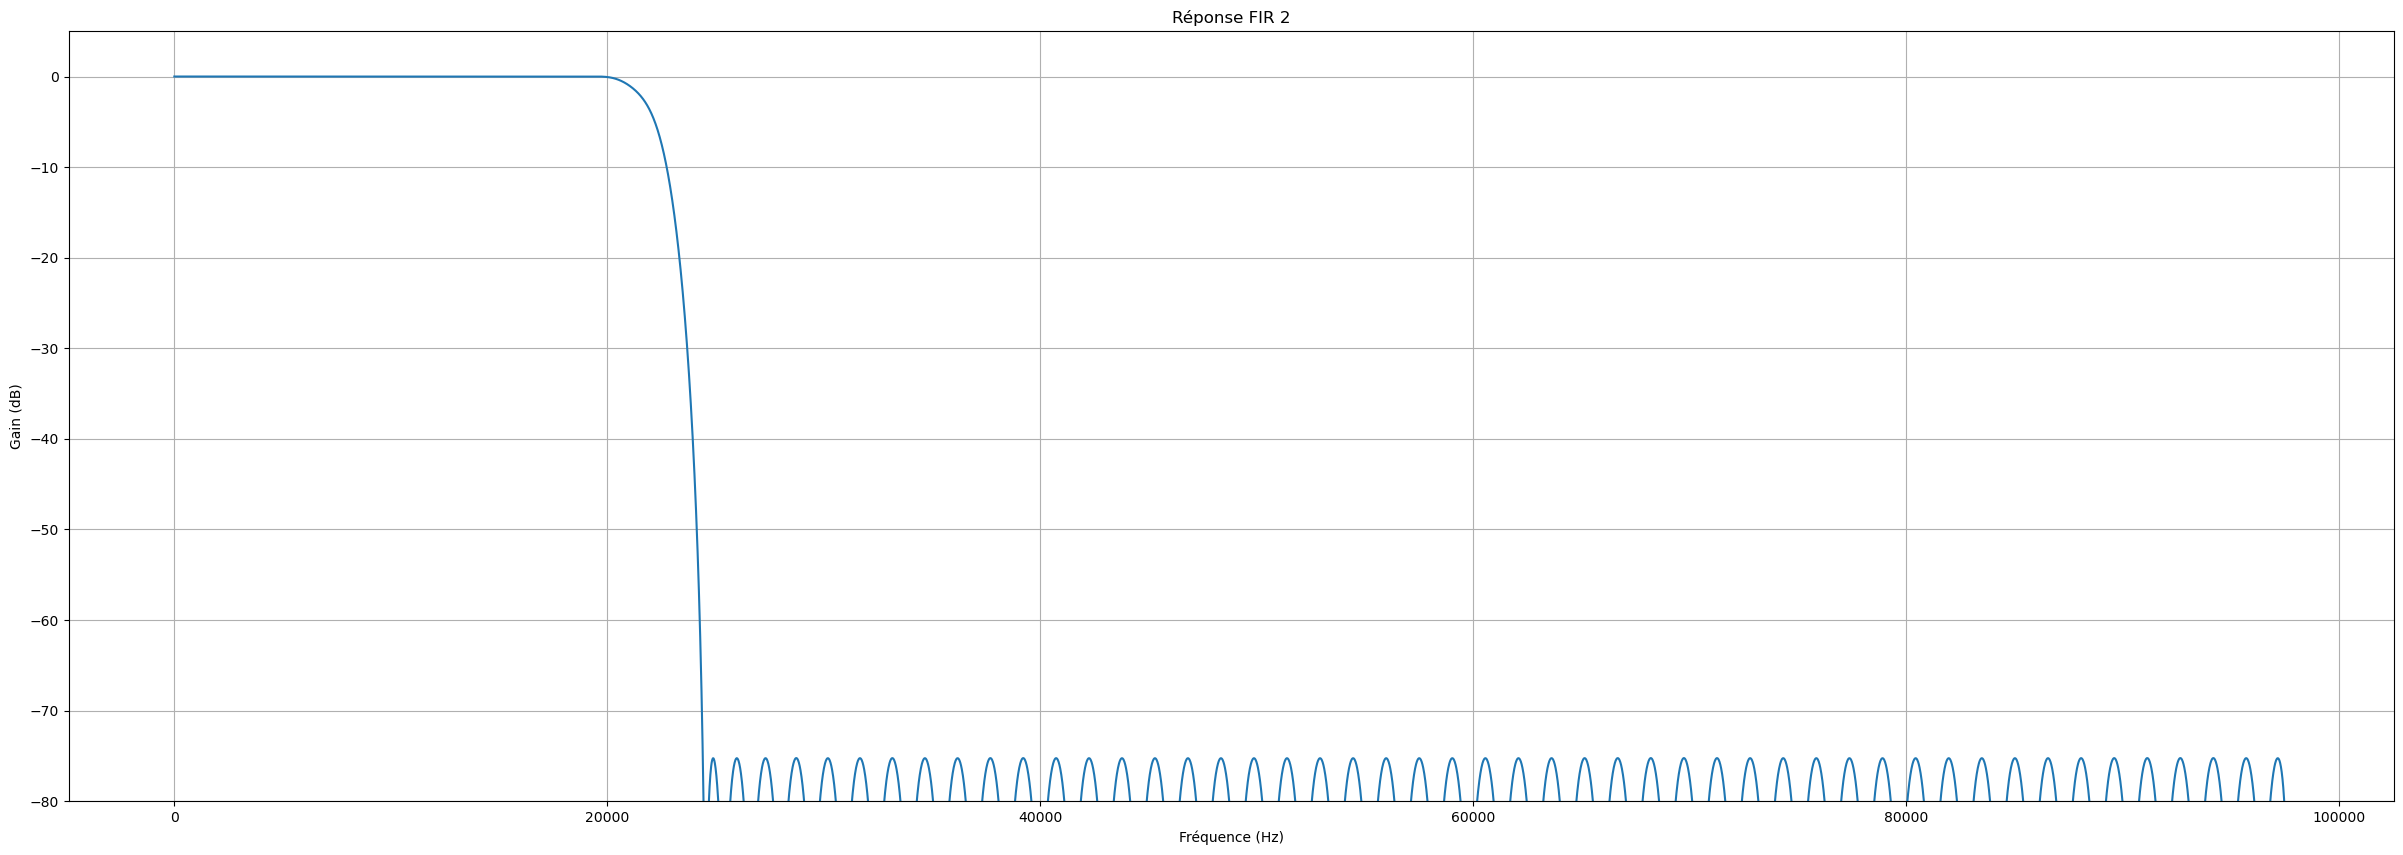

Ripple dans la bande passante (equiripple): +/- 7.30658513973248e-05
Atténuation minimum dans la stopband:  -75.2361648518657


In [11]:
from scipy import signal
    
cutoff1 = (frow/2**5)/2   # Fréquence de coupure le filtre doit couper au Fs/2 de la nouvelle fréquence de sampling

trans_width1 = cutoff1/10  # bande de transistion. Le facteur 10 est assez arbitraire. cela est du au fait que l'on a pas besoin de couper raide et que l'on ne cherche qu'une stabilité d'amplitude dasn la bande fs_DAC/2 et pas toute la bandpass.

numtaps1 = 256      # Taille du filtre: est symétrique et en puissance de 2 pour implémentation VHDL facilité.

taps1 = signal.firwin2(numtaps1, [0, cutoff1,cutoff1+trans_width1, 0.5*frow],[1, 1,0,0],nfreqs=None, window='blackman', nyq=None, antisymmetric=False, fs=frow)

print(taps1)

f, h = signal.freqz(taps1, [1], worN=8192, fs=frow)

plot_FIR(f, h, "Réponse FIR 1",-140)

plt.show()

# ripple bande 0-24kHz
for i,f_val in enumerate(f):
    if f_val>=fs_DAC/2:
        break

amp=np.abs(h)
ripple1=max(amp[0:i-1])-min(amp[0:i-1])
#print(max(amp[0:i-1]),min(amp[0:i-1]))
print("Ripple dans la bande d'intérêt: +/-",ripple1/2)

#attenuation min stopband
for i,f_val in enumerate(f):
    if f_val>=cutoff1+trans_width1:
        break

att1=max(amp[i:-1])
print("Atténuation minimum dans la stopband: ",20*np.log10(att1))

        
fs=cutoff1*2 #fs après première décimation
    
cutoff2 = (fs/2**2)/2 #pour décimation par 4

trans_width2 = cutoff2/5 # bande de transistion

numtaps2 = 256      # Taille du filtre: est symétrique et en puissance de 2 pour implémentation VHDL facilité.

taps2 = signal.remez(numtaps2, [0, cutoff2-trans_width2, cutoff2 , 0.5*fs],[1, 10**(-80/20)], fs=fs)
print(taps2)

f, h = signal.freqz(taps2, [1], worN=8096, fs=fs)

plot_FIR(f, h, "Réponse FIR 2",-80)

plt.show()

# ripple bande 0-24kHz
for i,f_val in enumerate(f):
    if f_val>=fs_DAC/2-fs_DAC/8:
        break

amp=np.abs(h)
ripple2=max(amp[0:i-1])-min(amp[0:i-1])
print("Ripple dans la bande passante (equiripple): +/-",ripple2/2)

#attenuation min stopband
for i,f_val in enumerate(f):
    if f_val>=cutoff2:
        break

att2=max(amp[i:-1])
print("Atténuation minimum dans la stopband: ",20*np.log10(att2))

Au vu du dernier filtre, le signal de scan AMP SQUID devra avoir une bande passante de 20kHz maximum

En considérant une bande passante égale à 0.35/Tr on a:

In [6]:
BW_maxi=20e3
Tr_maxi=0.35/BW_maxi
print("Temps de monté max vis à vis de la bande passante: ",Tr_maxi)

Temps de monté max vis à vis de la bande passante:  1.75e-05


Retard des filtres

In [7]:
retard1=1/frow*len(taps1)/2 
retard2=1/fs*len(taps2)/2
print("Retard des filtres: ",retard1,"s / ",retard2,"s")

Retard des filtres:  2.048e-05 s /  0.00065536 s


In [8]:
#Algo de décimation

def decimate(Signal,Taps, M): #prends des Taps symétriques afin de coder proche du VHDL
    """
    Fonction opérant la décimation d'un signal par un facteur M en utilisant le filtre défini par Taps (FIR symétrique)
    """
    nTaps=len(Taps)
    
    if len(Signal)<nTaps:
        print("Erreur: Le nombre d'échantillons n'est pas suffisant vis à vis de la taille du filtre")
        return Signal
       
    if nTaps%2!=0:
        print("Erreur: Le nombre de Taps n'est pas pair")
        return Signal
    
    Signal_out=[]
    for i,val in enumerate(Signal):
        #on prends les nTaps valeurs tous les M
        if i%M==0:
            out=0
            if i+nTaps>len(Signal)-1:
                break
            for j in range(int(nTaps/2)):
                #debug
                #print("indice début: ",i+j,"indice fin: ",(nTaps-1)+i-j,"indice FIR: ",j)
                #fin debug
                out+=(Signal[i+j]+Signal[(nTaps-1)+i-j])*Taps[j]
            Signal_out.append(out)
            
    return Signal_out

#Plot temporel
def plot_temporel(t,val,titre,mark='-'):
    
    fig = plt.figure(figsize=(30,10))
    
    ax = fig.add_subplot(111)

    ax.plot(t, val,mark)

    ax.set_ylim(min(val)-1, max(val)+1)

    ax.grid(True)

    ax.set_xlabel('Temps (s)')

    ax.set_ylabel('Signal')

    ax.set_title(titre)

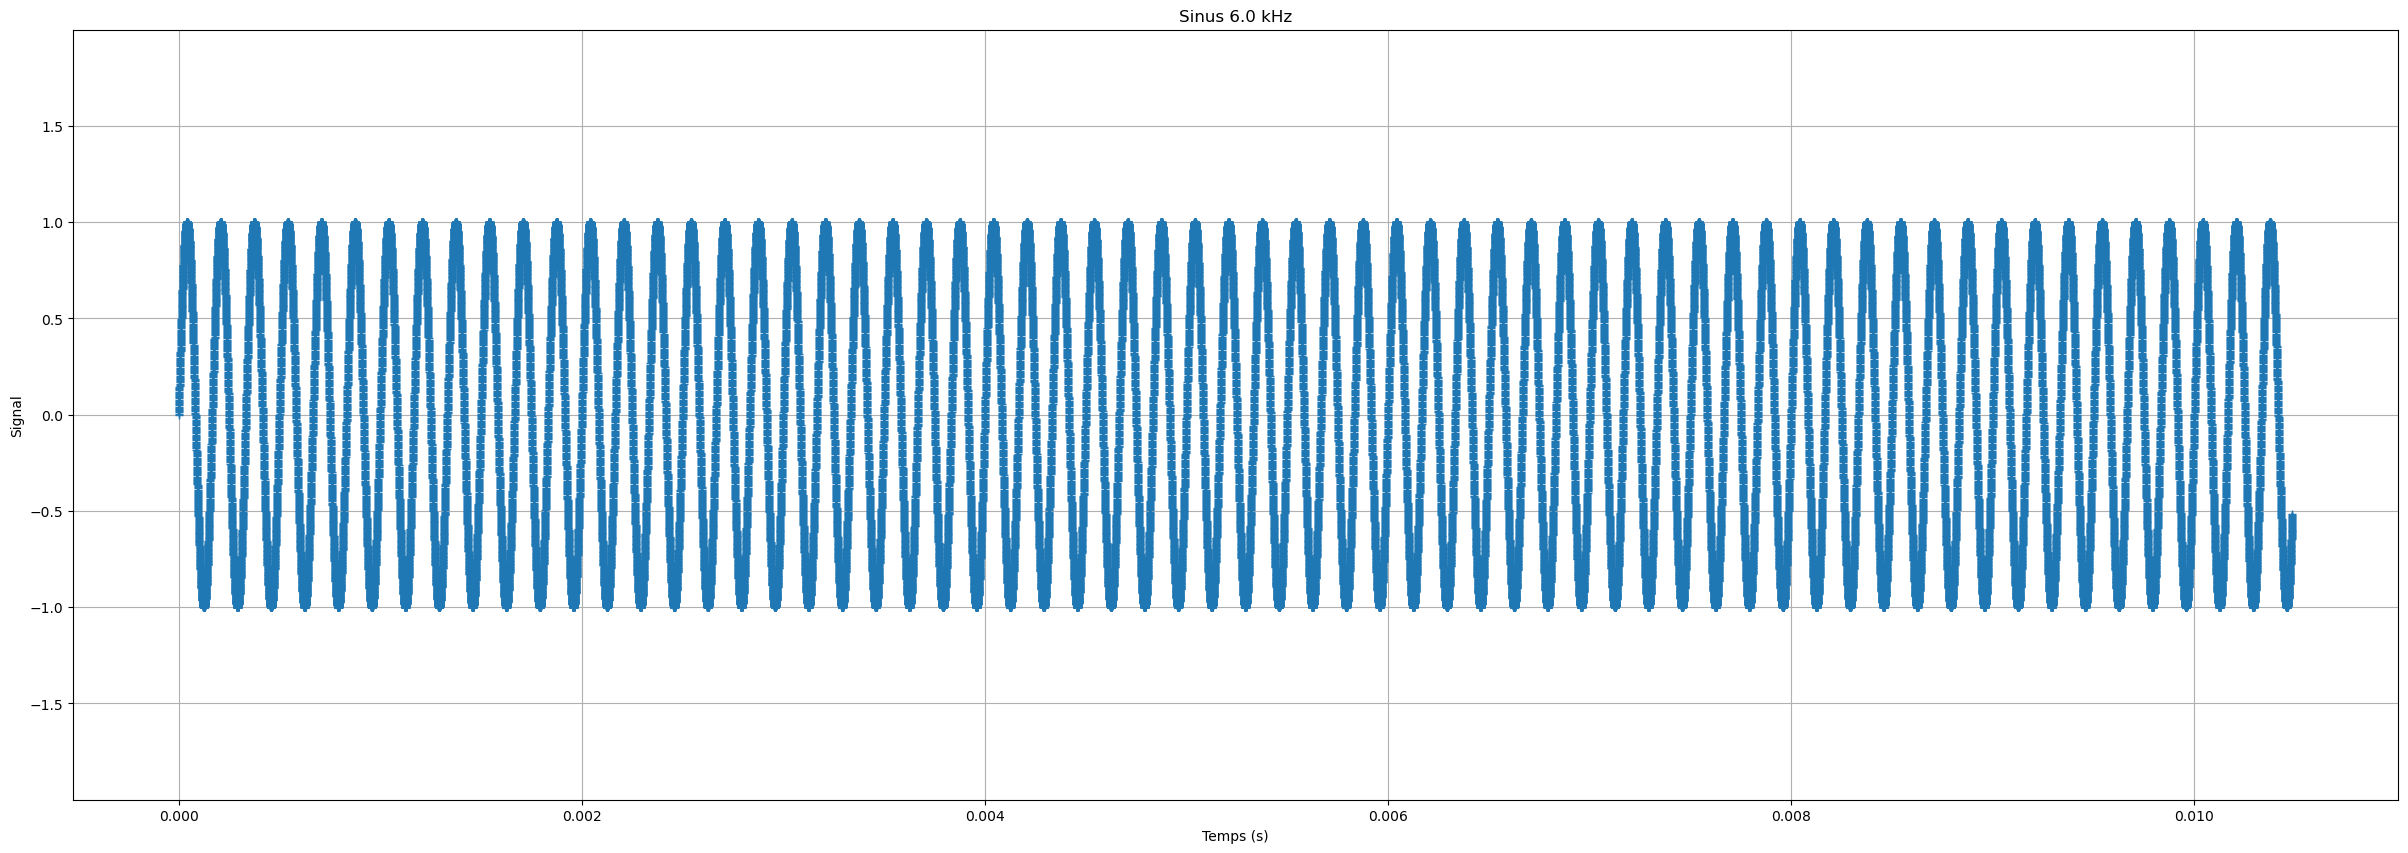

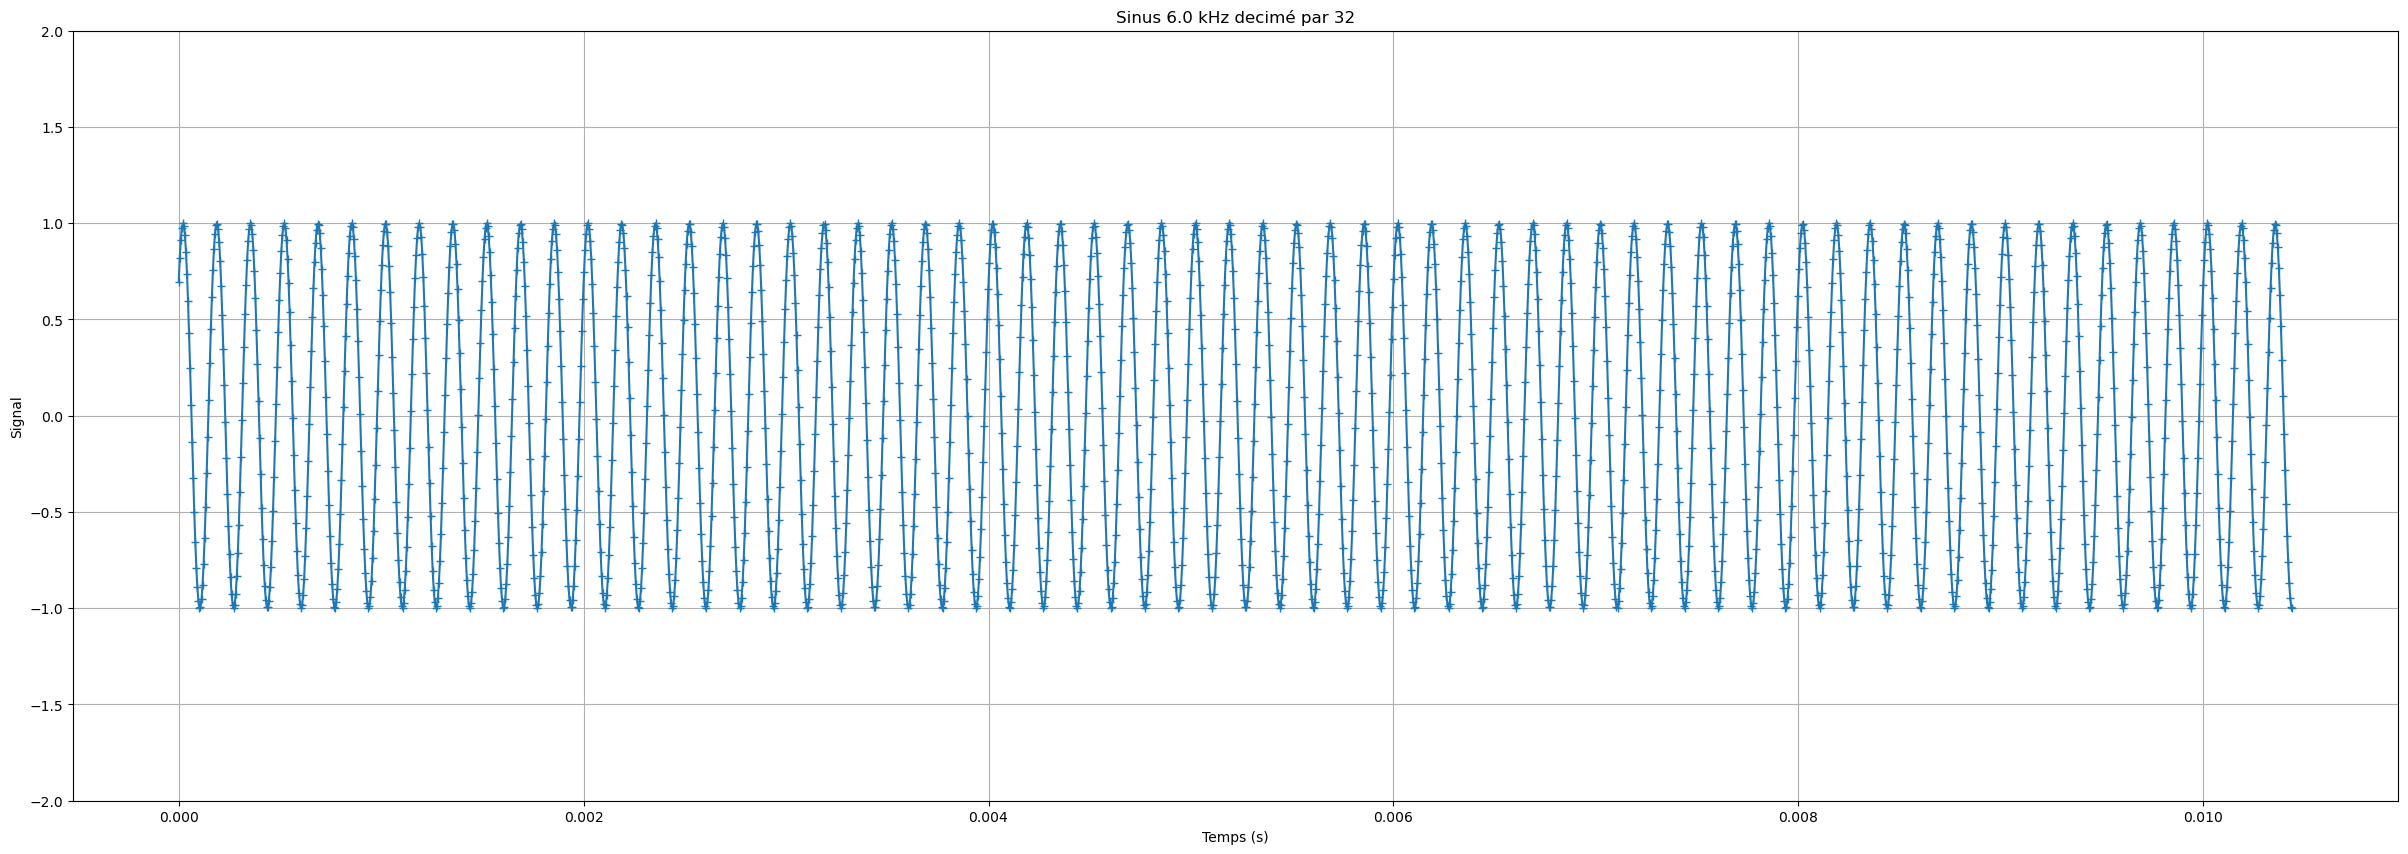

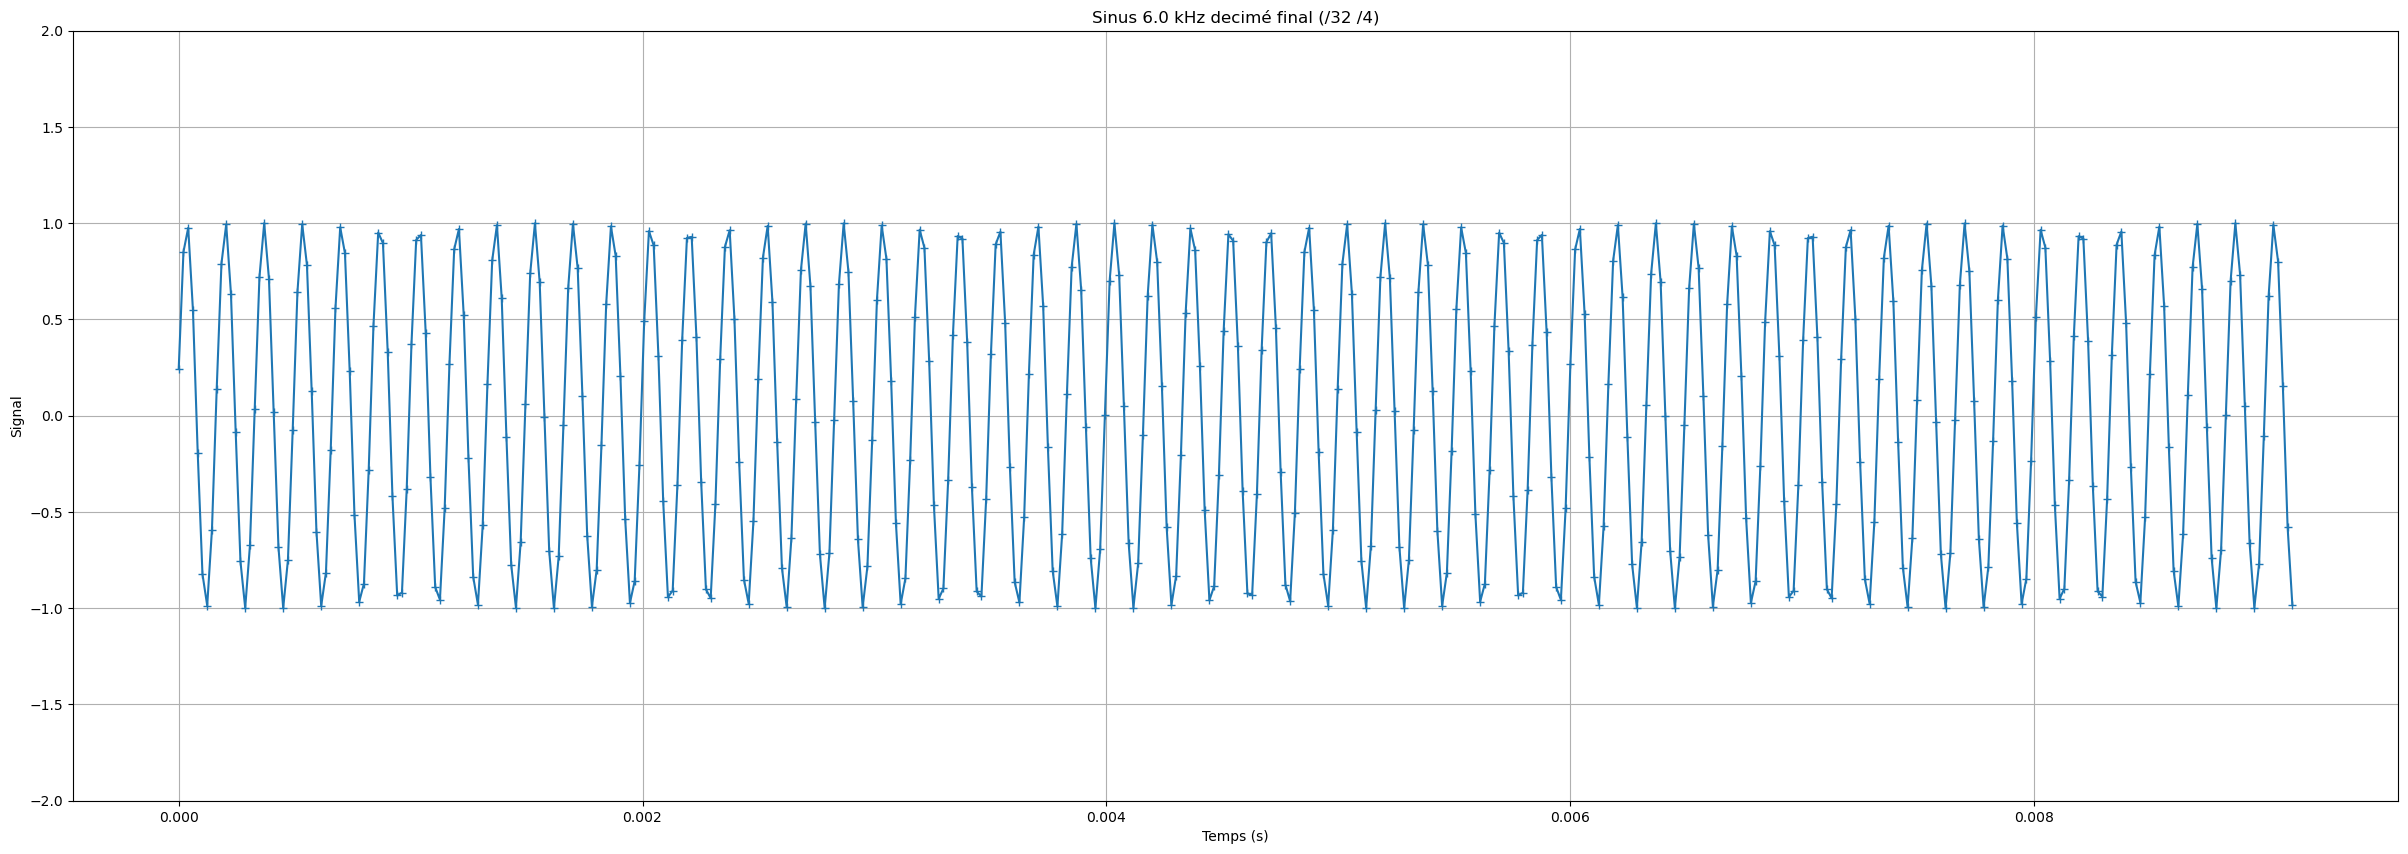

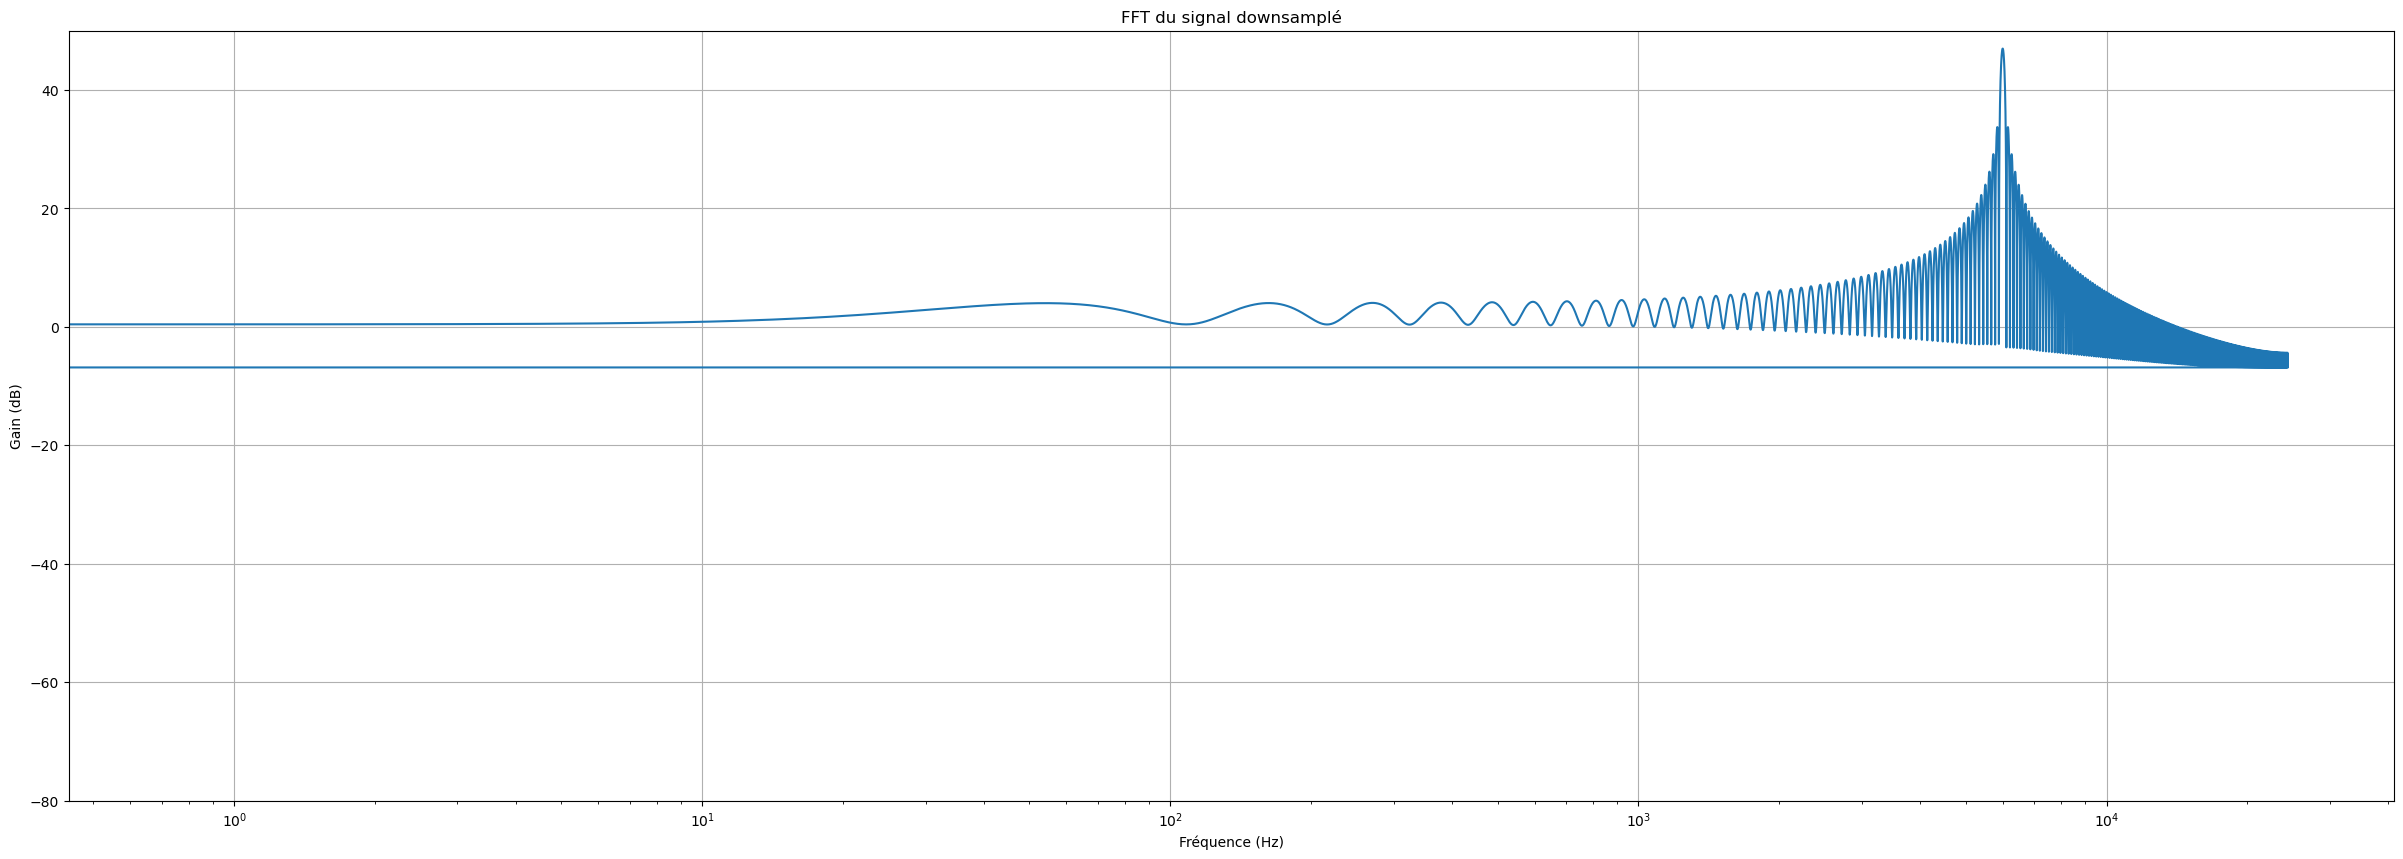

fréquence du sinus par FFT: -5999.952554702759


In [9]:

#sinus
#nb_samples = int(np.ceil((retard1+retard2)*2*10*frow))
nb_samples = 2**16
time=np.arange(0,nb_samples/frow,1/frow)
fsin=6e3
signal=np.sin(2*np.pi*fsin*time)

plot_temporel(time,signal,"Sinus "+str(fsin*1e-3)+" kHz",'+-')

decimated_signal_1 = decimate(signal,taps1,32)

plot_temporel([val*32/frow for val in range(len(decimated_signal_1))],decimated_signal_1,"Sinus "+str(fsin*1e-3)+" kHz decimé par 32",mark='+-')

decimated_signal_2 = decimate(decimated_signal_1,taps2,4)

plot_temporel([val*4/fs for val in range(len(decimated_signal_2))],decimated_signal_2,"Sinus "+str(fsin*1e-3)+" kHz decimé final (/32 /4)",mark='+-')

length_fft = max(len(decimated_signal_2),2**16)
out_fft=np.fft.fft(decimated_signal_2,length_fft)
freq=np.fft.fftfreq(length_fft,d=1/fs_DAC)

fig = plt.figure(figsize=(30,10))
    
ax = fig.add_subplot(111)

ax.semilogx(freq, 20*np.log10(np.abs(out_fft)))

ax.set_ylim(-80, 50)

ax.grid(True)

ax.set_xlabel('Fréquence (Hz)')

ax.set_ylabel('Gain (dB)')

ax.set_title("FFT du signal downsamplé")

plt.show()

print("fréquence du sinus par FFT: "+str(freq[np.argmax(np.abs(out_fft))]))

Tracé en bruit du downsampling

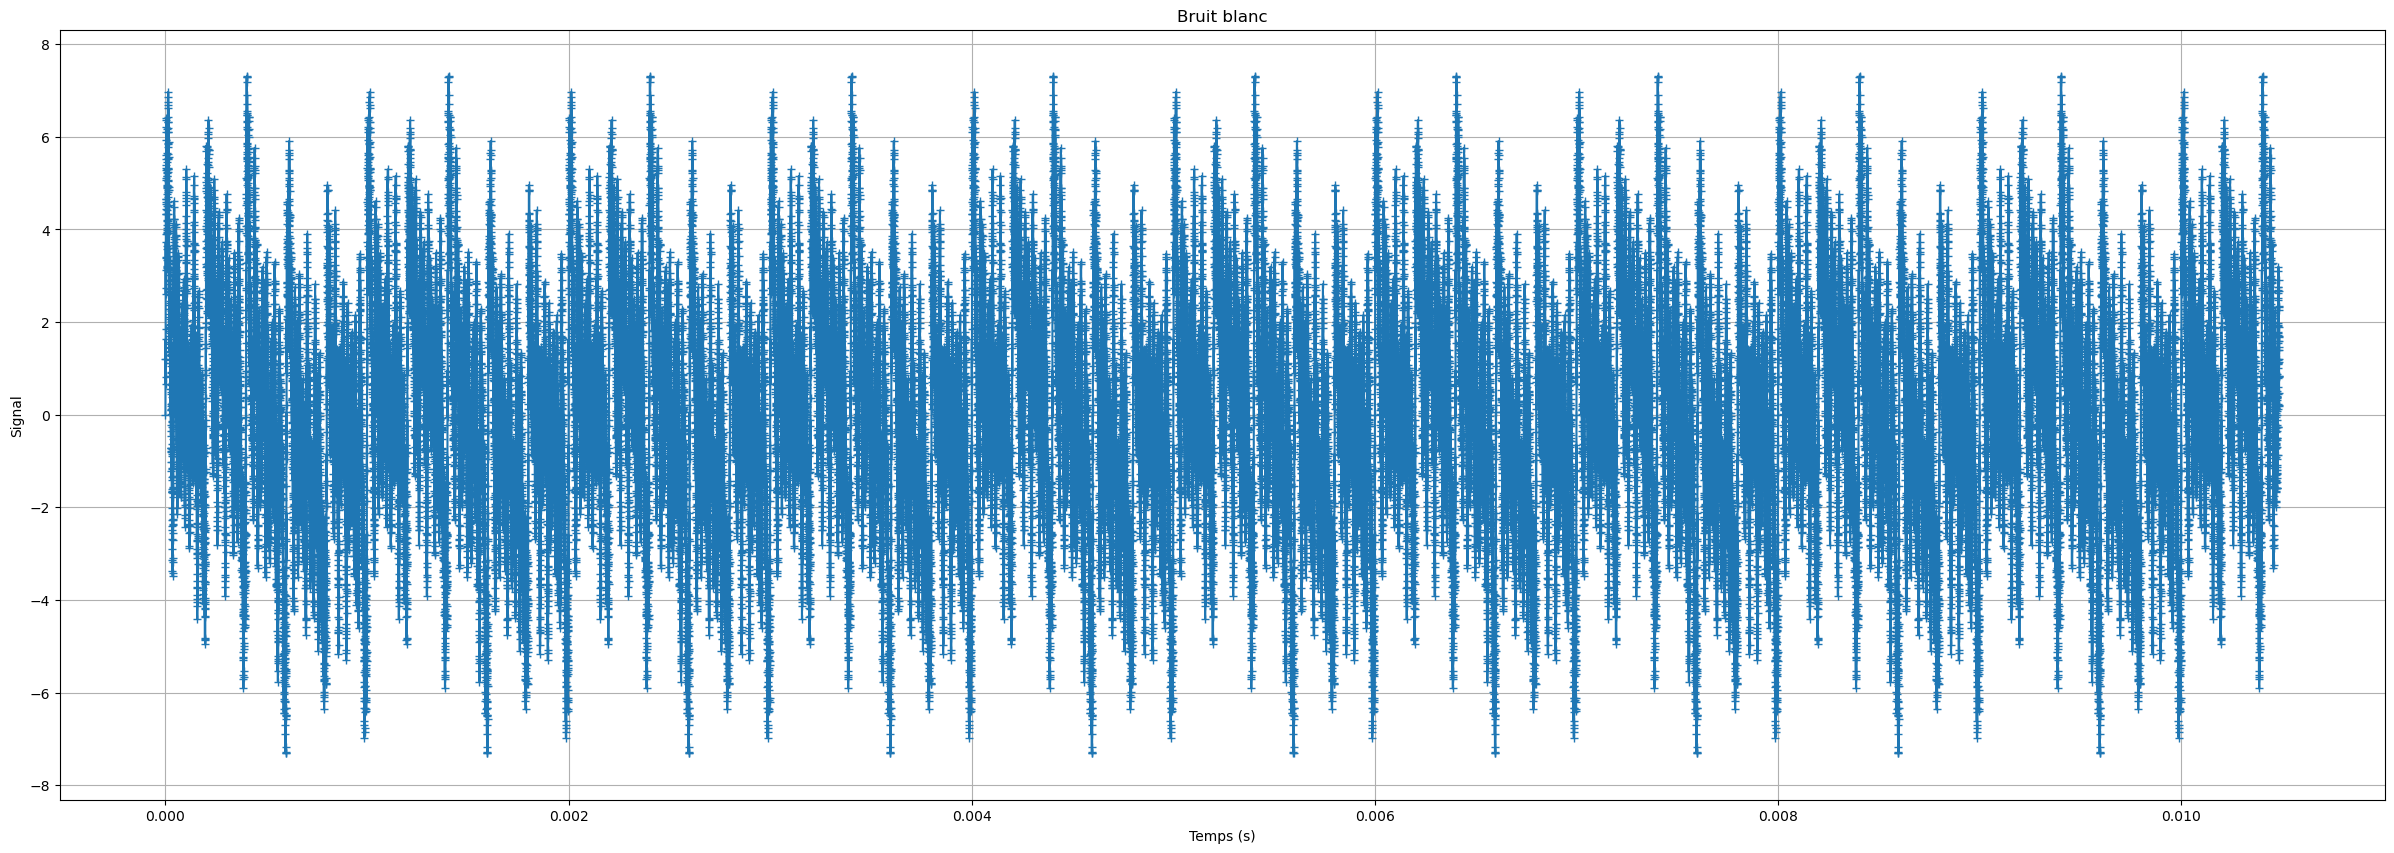

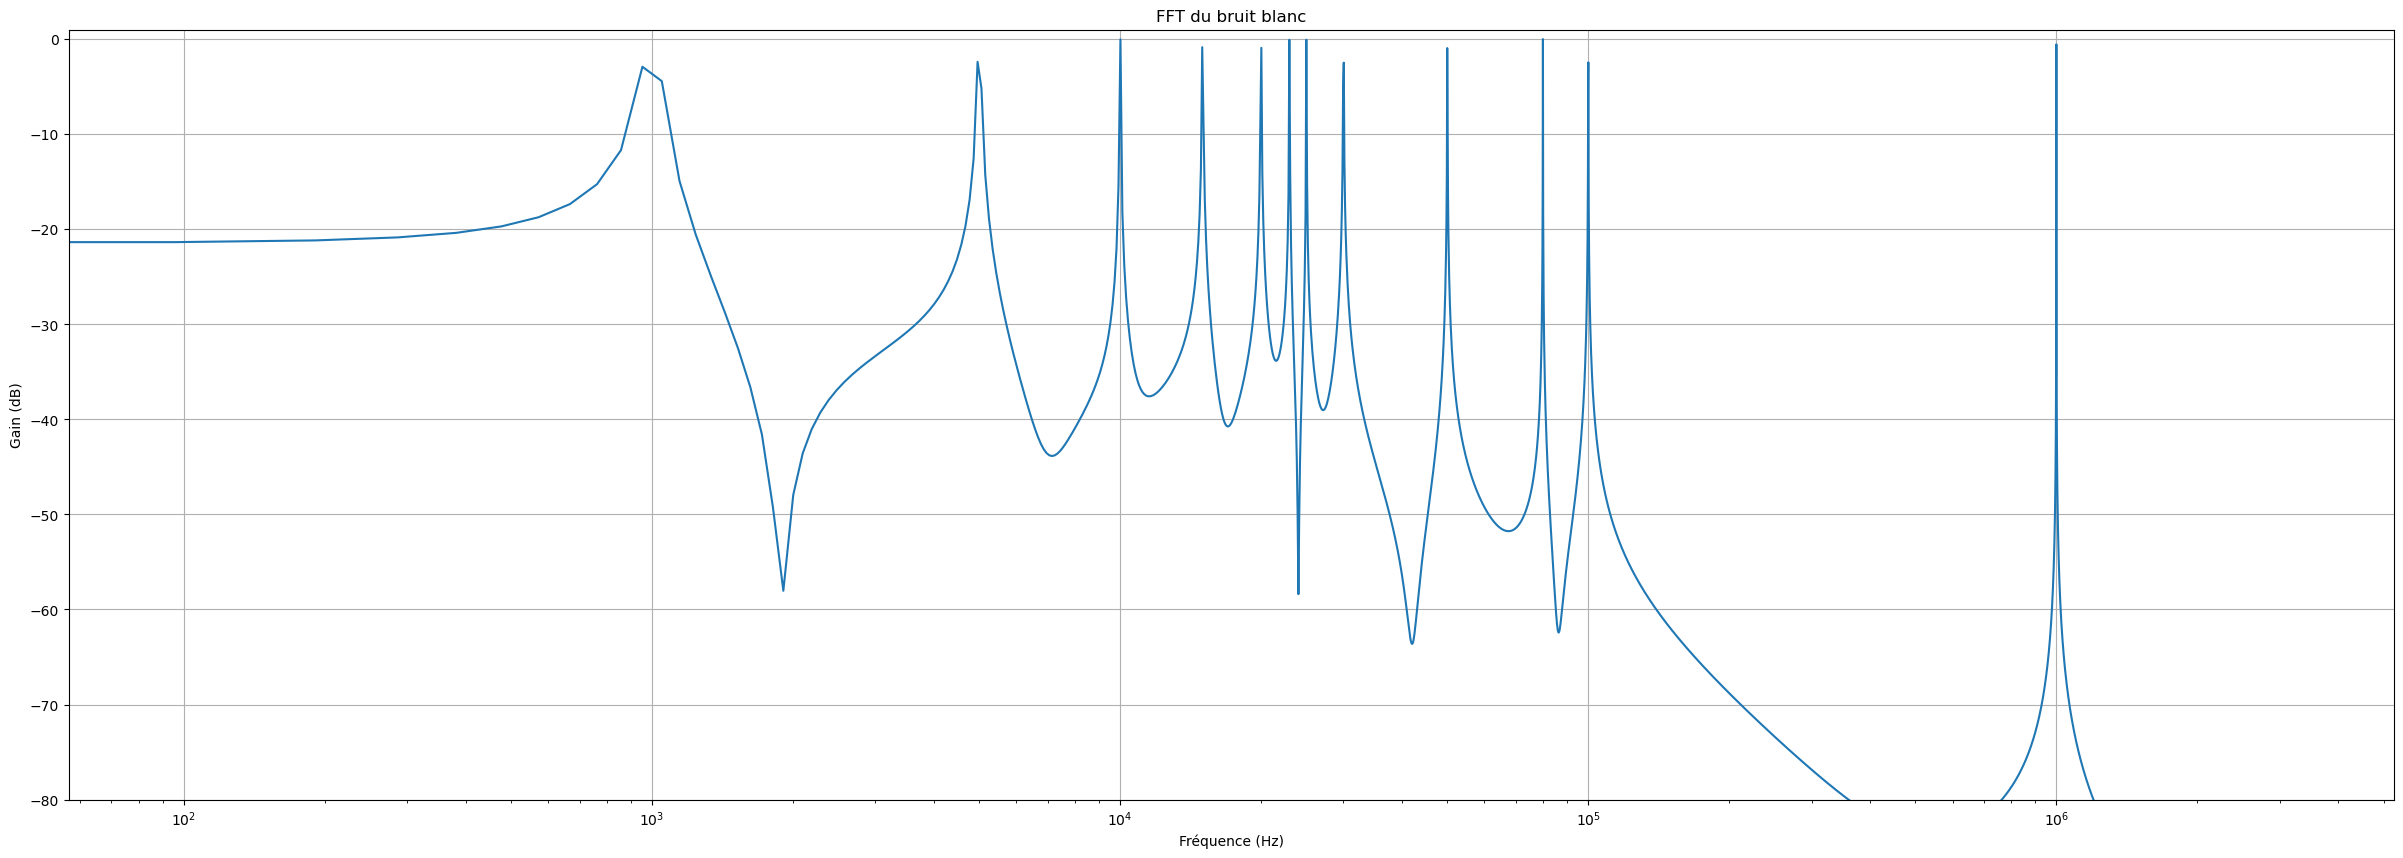

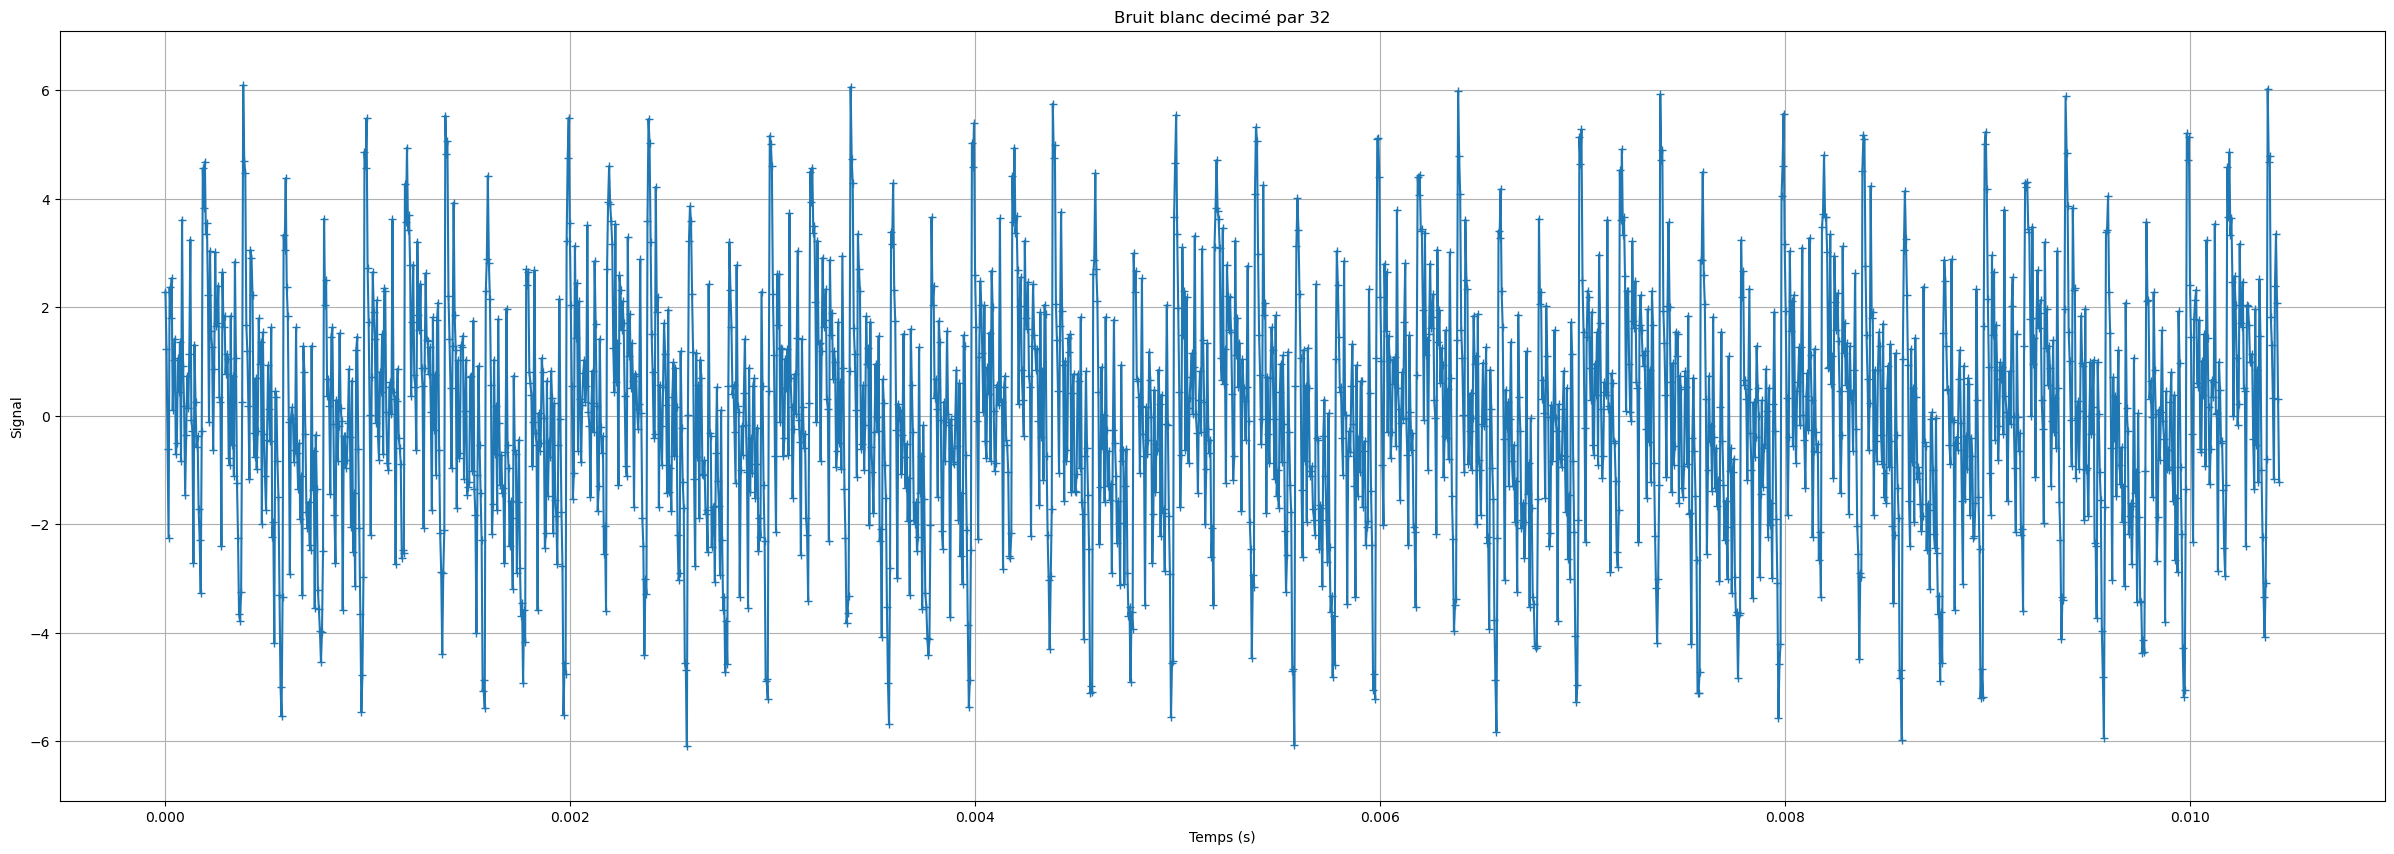

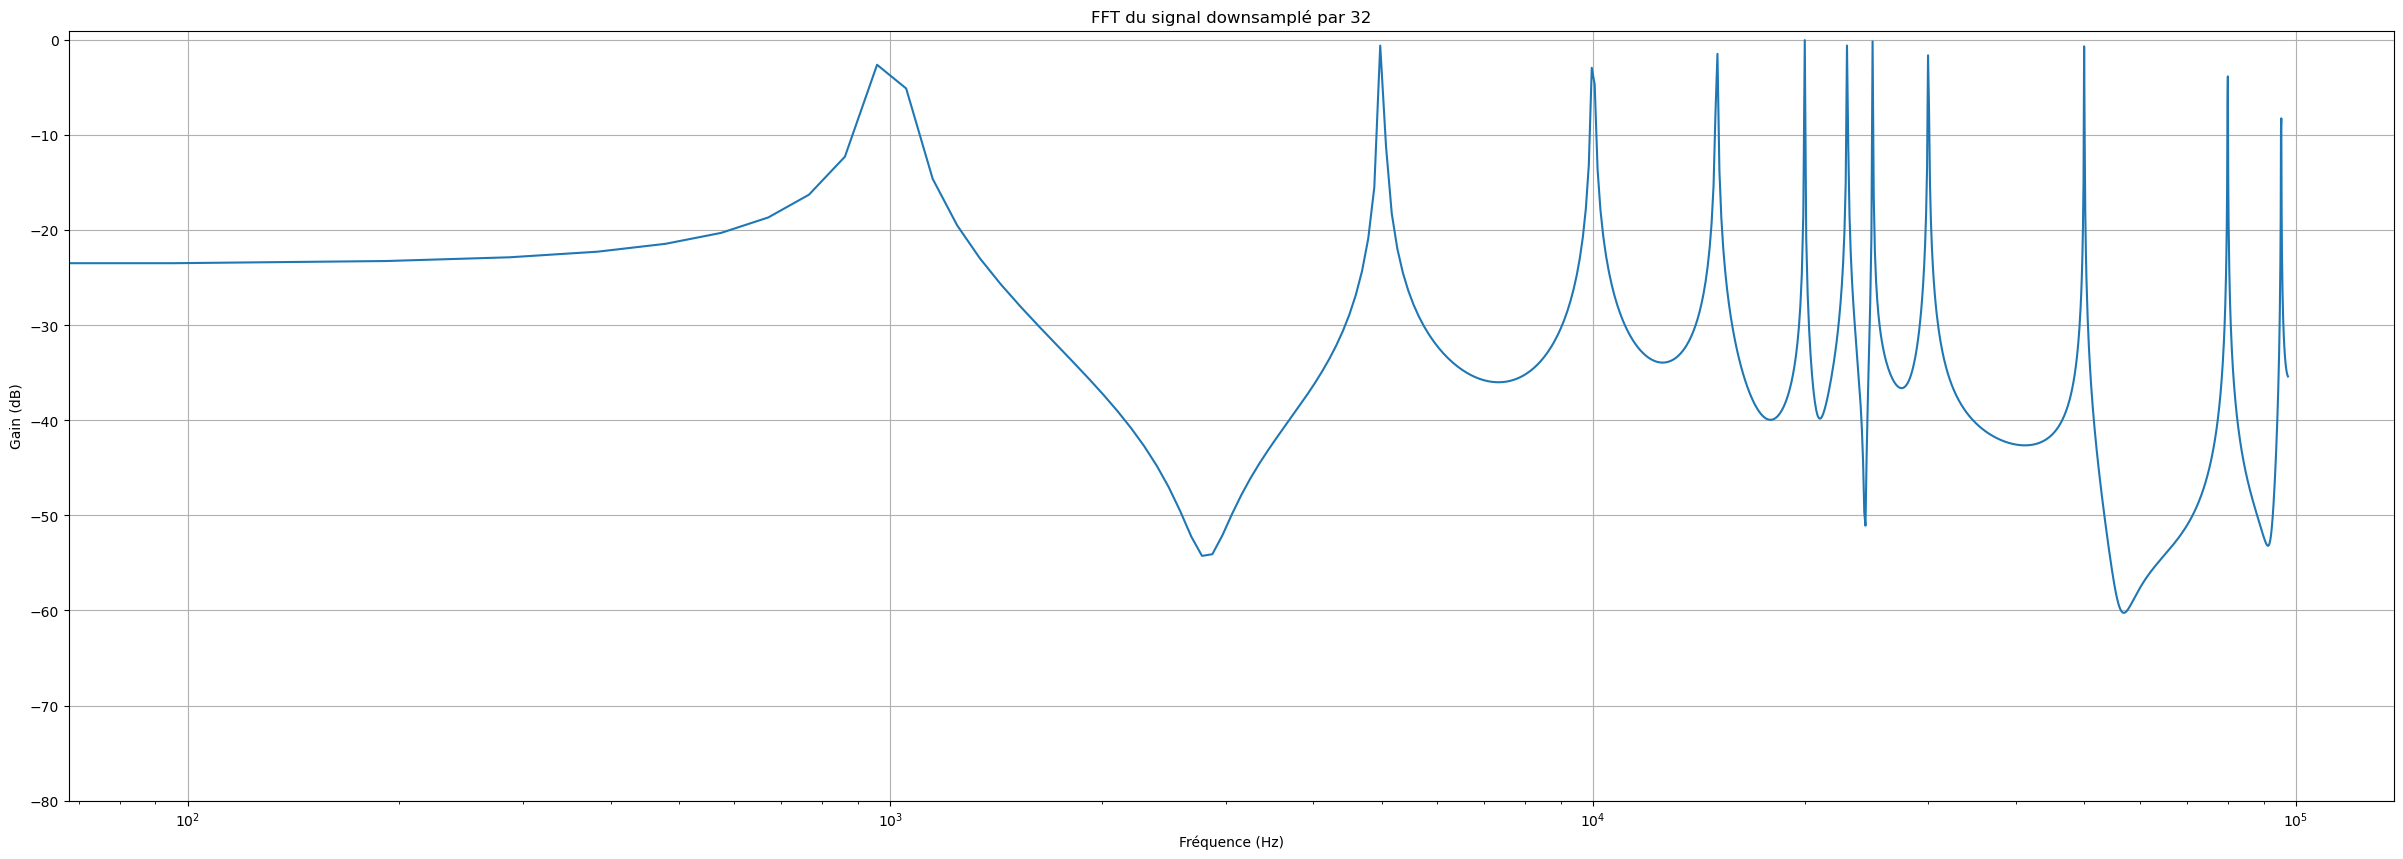

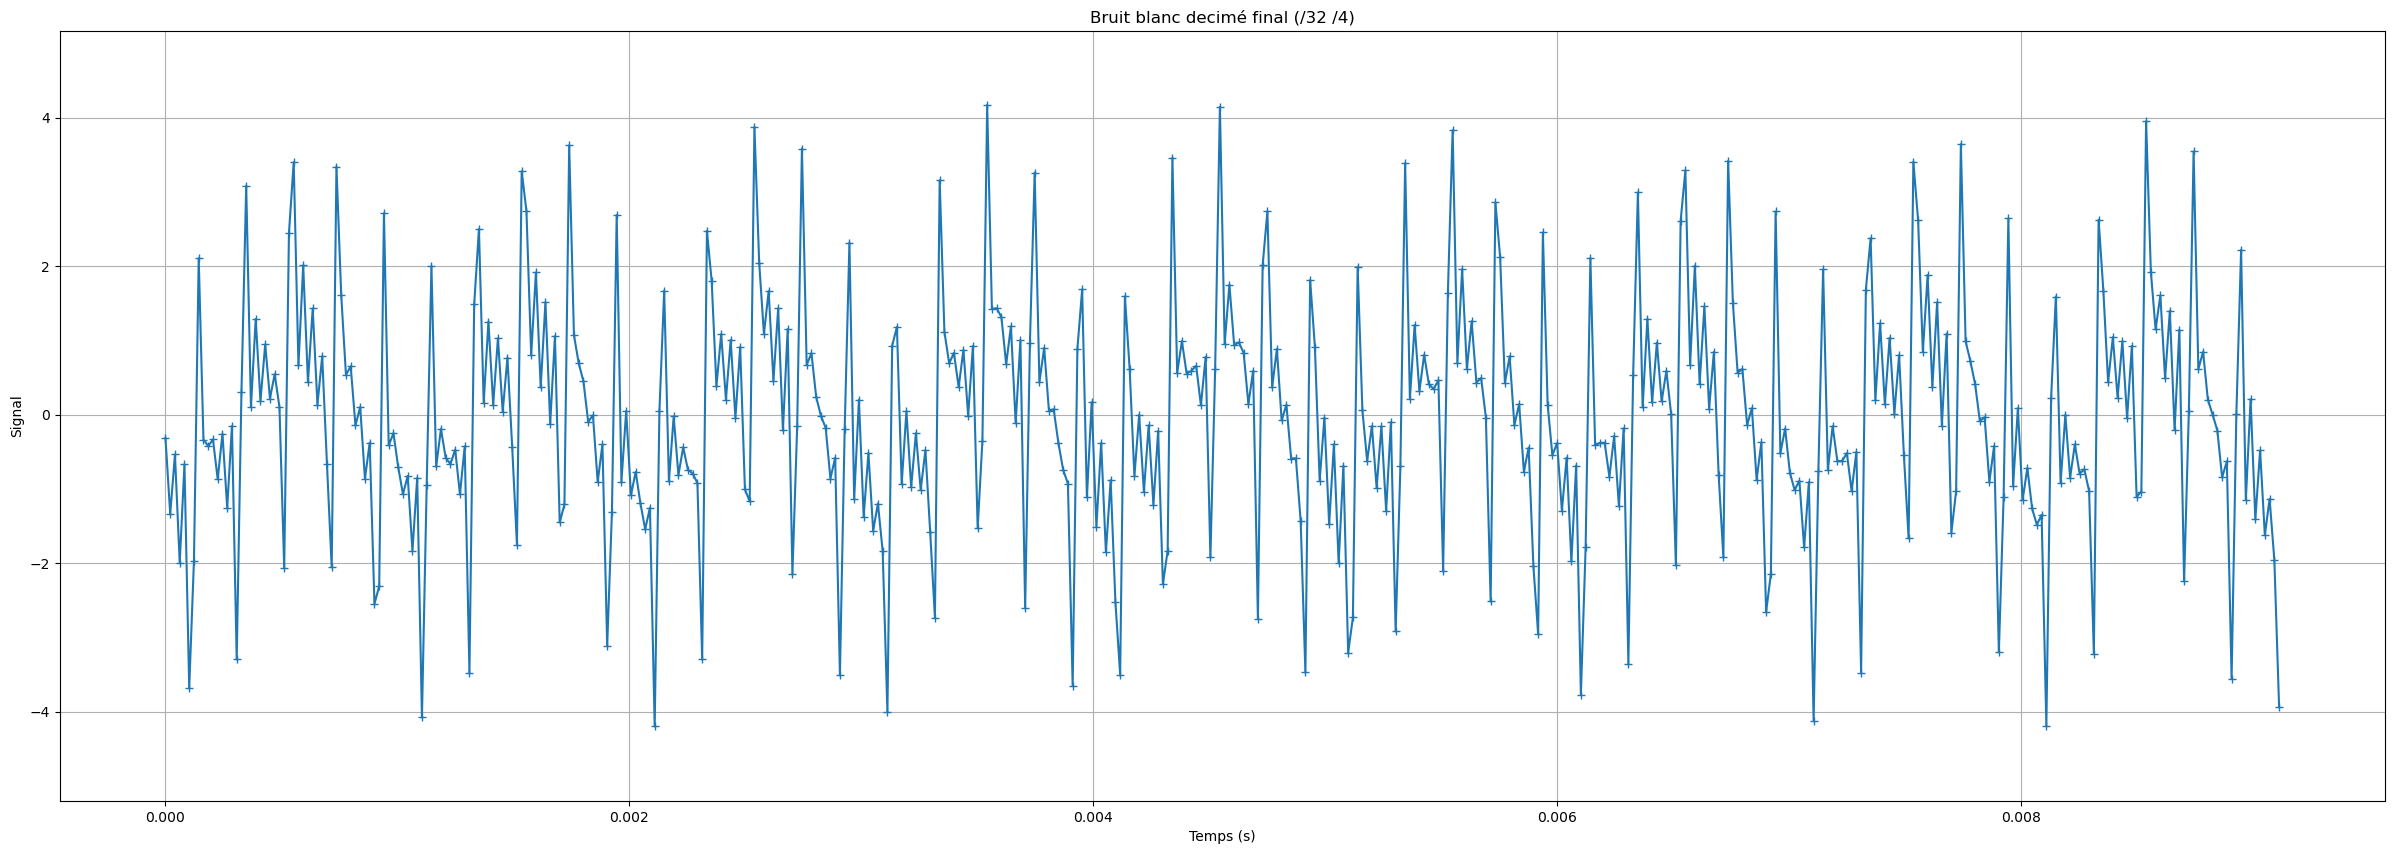

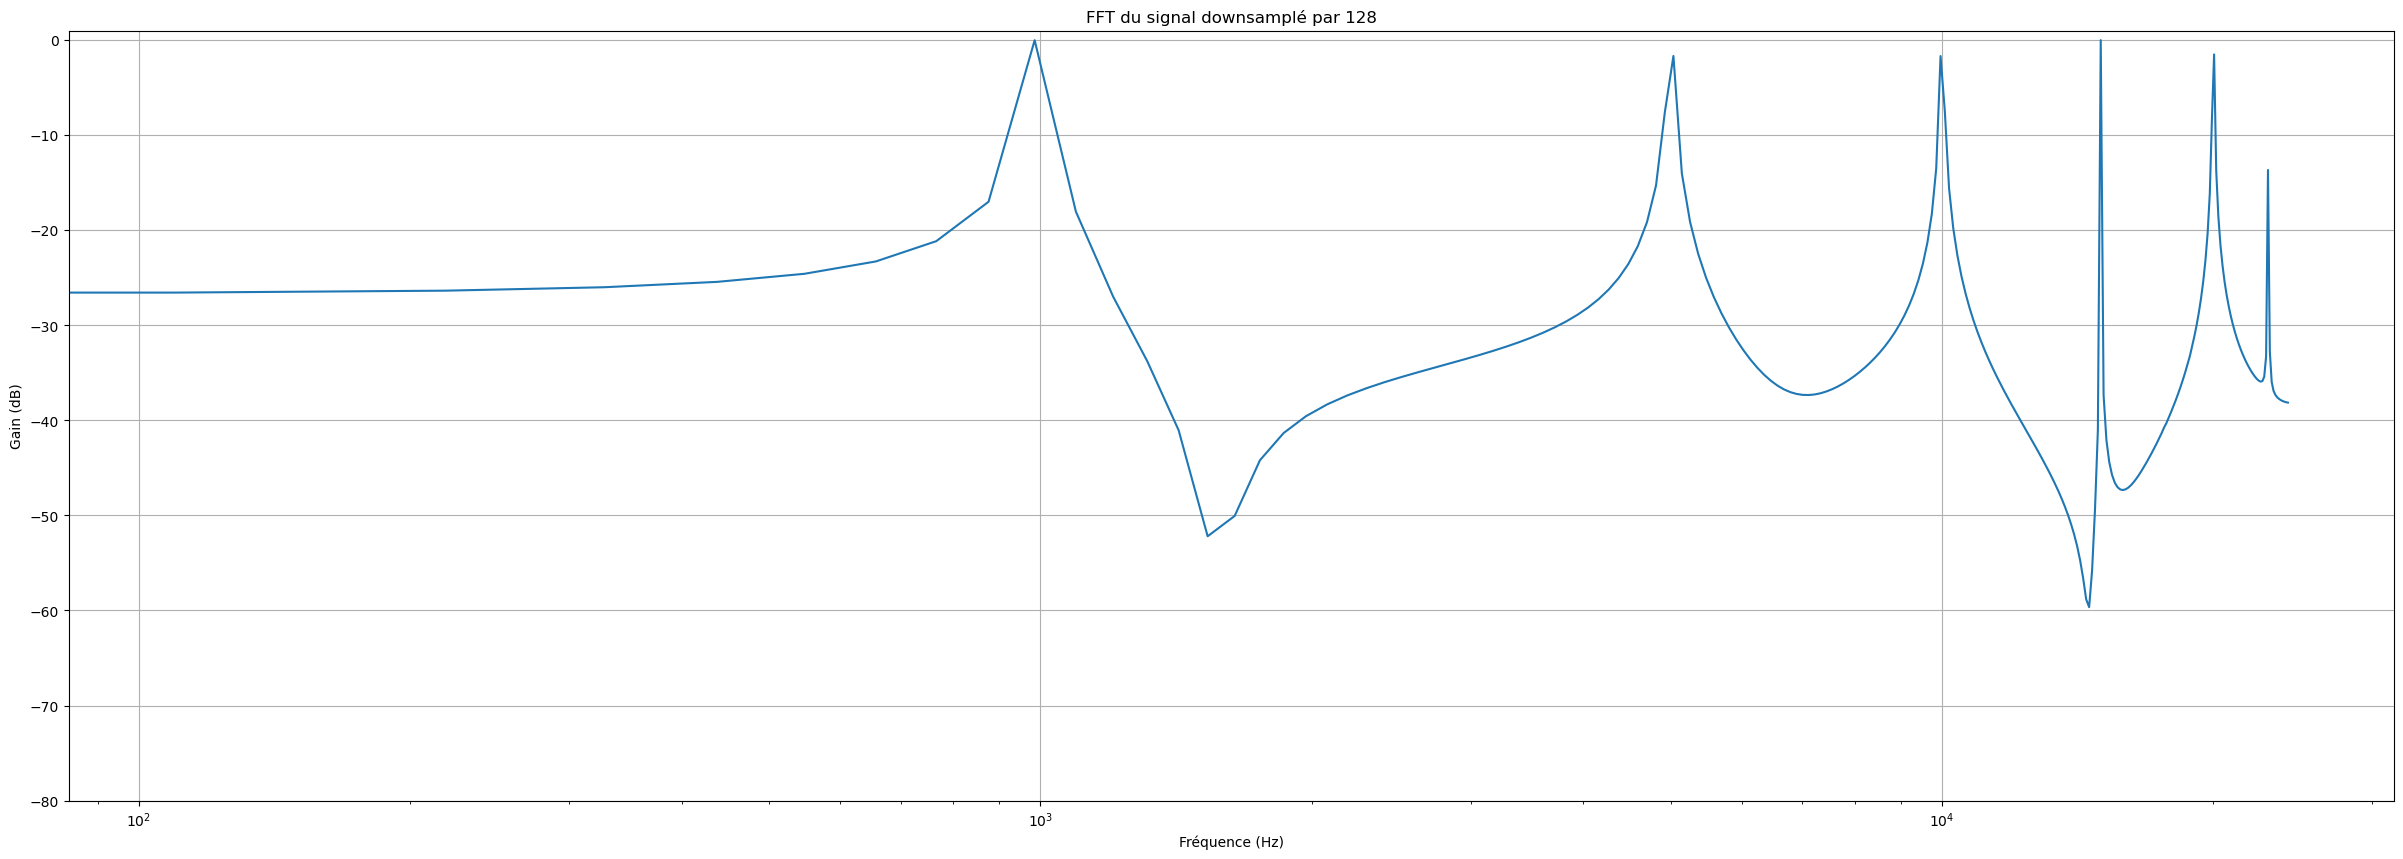

In [10]:
#plot frequentiel
def plot_freq(sig,fs,titre):

    length_fft = len(sig)
    out_fft=np.fft.fft(sig,length_fft)
    freq=np.fft.fftfreq(length_fft,d=1/fs)

    if length_fft%2==0:
        ind_max=int(length_fft/2-1)
    else:
        ind_max=int((length_fft-1)/2)   
    
    fig = plt.figure(figsize=(30,10))

    ax = fig.add_subplot(111)

    norm=max(20*np.log10(np.abs(out_fft[0:ind_max])))
    
    ax.semilogx(freq[0:ind_max], 20*np.log10(np.abs(out_fft[0:ind_max]))-norm)

    ax.set_ylim(-80, 1)

    ax.grid(True)

    ax.set_xlabel('Fréquence (Hz)')

    ax.set_ylabel('Gain (dB)')

    ax.set_title(titre)


#generation bruit blanc
#signal = np.random.normal(size=len(time))

#generateur comb sinus
freqs_sin=np.array([1e3,5e3,10e3,15e3,20e3,23e3,25e3,30e3,50e3,80e3,100e3,1e6])   
signal=[sum(np.sin(2*np.pi*freqs_sin*t)) for t in time]    


plot_temporel(time,signal,"Bruit blanc",'+-')
plot_freq(signal,frow,"FFT du bruit blanc")

decimated_signal_1 = decimate(signal,taps1,32)

plot_temporel([val*32/frow for val in range(len(decimated_signal_1))],decimated_signal_1,"Bruit blanc decimé par 32",mark='+-')
plot_freq(decimated_signal_1,frow/32,"FFT du signal downsamplé par 32")

decimated_signal_2 = decimate(decimated_signal_1,taps2,4)

plot_temporel([val*4/fs for val in range(len(decimated_signal_2))],decimated_signal_2,"Bruit blanc decimé final (/32 /4)",mark='+-')
plot_freq(decimated_signal_2,fs_DAC,"FFT du signal downsamplé par 128")

plt.show()